# Demo: Configs

In 1.1, we saw how you could load and transform a fits file into something that's ML ready through a series of preprocessing functions. In this tutorial, we make the process even more concrete, by showing how you can use a config file which only needs to be set up once, and use that to download and save the ml ready solar data.

In [19]:
import toolz 
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
from helio_tools._src.utils.io import get_list_filenames

base_path = os.getcwd() + "/sdo-data"
ext = ".fits"

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))



580


## Preprocessing

### Preprocessing Steps

1) **Filter Files for Wavelength**.

First, we will filter the files for the wavelength `304`. 
We will also only take a demo file for this demonstration.

2) **`.fits` file to `Map`**


Next, we will load the `.fits` file to a `sunpy.map.Map` object. 
This is a very convenient object to work with because `.fits` files are very unintuitive for the inexperienced. 
So we will use this higher order wrapper instead of dealing directly with `.fits` files.

See the [sunpy.map](https://docs.sunpy.org/en/stable/reference/map.html) docs for more details.

3) **Normalized Radius**

Next, we will normalized the radius by some resolution. 
We also have the option to crop the edge bits that we don't want within the image.


4) **Correct Degregation**


5) **`Map` to `ndarray`

Now, we will change the data structure to a numpy.ndarray.
This is more convenient for some functionality, e.g., normalization. 
However, it is completely optional

6) **Normalize**

We will use some predefined normalization schemes found [here](https://github.com/spaceml-org/MDRAIT_ITI/blob/master/iti/data/editor.py#L60). 
We will define it here manually for more clarity.


7) **Channel Dimension**

We would like to save our new image to be "ML-Ready". 
However, we need to save it in an image-like format.
We are using the `numpy` convention so we'll save it as: 

`Height x Width x Channel`

We can directly plot the image along with the distribution of pixels and the associated meta-data.

## Configurations

In [6]:
from helio_tools._src.editors.load import load_fits_to_map
from helio_tools._src.editors.scale import normalize_radius, normalize_fn
from helio_tools._src.editors.calibration import correct_degregation
from helio_tools._src.editors.datastructure import map_to_ndarray
from astropy.visualization import ImageNormalize, AsinhStretch
from einops import rearrange
import hydra_zen

In [7]:
def zen_compose(d):
    return toolz.compose_left(*(d[k] for k in sorted(d)))


In [9]:
from dataclasses import asdict

init_partial_fn = hydra_zen.make_custom_builds_fn(zen_partial=True)
init_fn = hydra_zen.make_custom_builds_fn(zen_partial=False)



def from_recipe(rec):
    return init_partial_fn(toolz.apply, init_fn(zen_compose, asdict(rec)))

def from_recipe_and_inp(rec, inp):
    return init_partial_fn(toolz.apply, init_fn(zen_compose, asdict(rec)), inp)

In [10]:
resolution = 2048

base_prepro = hydra_zen.make_config(
    zen_dataclass={'cls_name': 'pre_process'},
    # 0 - get a filename
    _0=init_partial_fn(toolz.identity),
    # 1 - load fits file to a sunpy Map object
    _1=init_partial_fn(load_fits_to_map),
    # 2 - normalize radius via some resolution
    _2=init_partial_fn(normalize_radius, resolution=resolution, crop = True, padding_factor = 0.1),
    # 3 - correct degregation
    _3=init_partial_fn(correct_degregation, method = "auto"),
    # 4 - sunpy.map.Map --> numpy.ndarray
    _4=init_partial_fn(map_to_ndarray),
    # 5 - Normalize
    _5=init_partial_fn(
        normalize_fn, fn=init_fn(ImageNormalize, vmin=0, vmax=8_800, clip=True, stretch=init_fn(AsinhStretch, a=0.001))),
    # 6 - Reshape (Add batch dimension (?))
    _6=init_partial_fn(
        rearrange, pattern='H W -> H W 1', H=resolution, W=resolution)
)


We can print the file here so that we can see what it looks like and we can imagine a `.yaml` file with the configuration.

In [11]:
p_yaml = lambda cfg: print(hydra_zen.to_yaml(cfg, sort_keys=True))

# print yaml file
p_yaml(base_prepro)

_0:
  _partial_: true
  _target_: toolz.functoolz.identity
_1:
  _partial_: true
  _target_: helio_tools._src.editors.load.load_fits_to_map
_2:
  _partial_: true
  _target_: helio_tools._src.editors.scale.normalize_radius
  crop: true
  padding_factor: 0.1
  resolution: 2048
_3:
  _partial_: true
  _target_: helio_tools._src.editors.calibration.correct_degregation
  method: auto
_4:
  _partial_: true
  _target_: helio_tools._src.editors.datastructure.map_to_ndarray
_5:
  _partial_: true
  _target_: helio_tools._src.editors.scale.normalize_fn
  fn:
    _partial_: false
    _target_: astropy.visualization.mpl_normalize.ImageNormalize
    clip: true
    stretch:
      _partial_: false
      _target_: astropy.visualization.stretch.AsinhStretch
      a: 0.001
    vmax: 8800
    vmin: 0
_6:
  H: 2048
  W: 2048
  _partial_: true
  _target_: einops.einops.rearrange
  pattern: H W -> H W 1



### Saving Configs

Now, let's save the config file to a `.yaml` file.

In [12]:
from hydra_zen import save_as_yaml

In [13]:
# save to a yaml file
config_path = "./sdo_config.yaml"
save_as_yaml(base_prepro, f=config_path)

### Loading Configs

In [14]:
# initialize config
config = hydra_zen.load_from_yaml(config_path)

# load config
fn_asdicts = hydra_zen.instantiate(config)

#### Apply as pipeline

In [15]:
# create function from composition
fn = zen_compose(fn_asdicts)

In [16]:
# run function!
out = fn(data_filenames[0])

out.shape

(2048, 2048, 1)

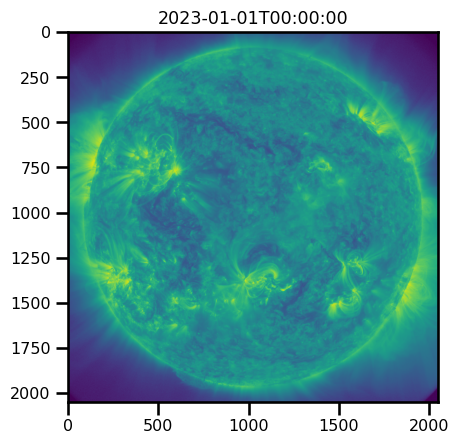

In [23]:
plt.title(data_filenames[0].split("/")[-1].split(".")[0].replace("_", " "))
plt.imshow(out[:, :, 0])